In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split


CitiBike  DATA


In [ ]:
# Load the datasets (replace with actual data paths if needed)
rides_2021 = pd.read_parquet("/content/cpz_station_timeseries_2021_yearly_15min.parquet")
rides_2022 = pd.read_parquet("/content/cpz_station_timeseries_2022_yearly_15min.parquet")
rides_2023 = pd.read_parquet("/content/cpz_station_timeseries_2023_yearly_15min.parquet")
rides_2024 = pd.read_parquet("/content/cpz_station_timeseries_2024_yearly_15min.parquet")


In [ ]:
# Combine the data for all years
rides_data = pd.concat([rides_2021, rides_2022, rides_2023, rides_2024], ignore_index=True)


In [ ]:
# Convert 'time_bucket' to datetime
rides_data['time_bucket'] = pd.to_datetime(rides_data['time_bucket'])


In [ ]:
# Aggregate the data to daily booking counts
rides_data['date'] = rides_data['time_bucket'].dt.date
daily_rides = rides_data.groupby(['start_station_id', 'date'])['booking_count'].sum().reset_index()


In [ ]:
urban_features = pd.read_csv("/content/commercial,Retail.csv")
urban_features = urban_features[['station_id', 'Supermarkets and Convenience Stores_500m',
                                 'Malls and Shopping Centers_500m', 'Restaurants, Cafes, and Bars_500m',
                                 'Retail Stores_500m']]

In [ ]:
stations_coordinates = pd.read_csv("/content/manhattan_stations_ Coordinates.csv")
stations_coordinates = stations_coordinates[['start_station_id', 'start_lat', 'start_lng']]
public_retail = pd.read_csv("/content/public,retail spaces.csv")
public_retail = public_retail[['station_id', 'Parks_500m', 'Libraries_500m', 'Colleges_500m', 'Attractions_500m', 'Athletics_500m']]


In [ ]:
# Merge the data
merged_data = daily_rides.merge(urban_features, left_on='start_station_id', right_on='station_id', how='left')
merged_data = merged_data.merge(stations_coordinates, left_on='start_station_id', right_on='start_station_id', how='left')
merged_data = merged_data.merge(public_retail, left_on='start_station_id', right_on='station_id', how='left')


In [ ]:
# Select a station (e.g., '4818.03')
station_id = '4818.03'  # Change this to your desired station ID
station_data = merged_data[merged_data['start_station_id'] == station_id]


In [ ]:
# Remove outliers using the IQR method
Q1 = station_data['booking_count'].quantile(0.25)
Q3 = station_data['booking_count'].quantile(0.75)
IQR = Q3 - Q1
station_data_clean = station_data[(station_data['booking_count'] >= (Q1 - 1.5 * IQR)) &
                                  (station_data['booking_count'] <= (Q3 + 1.5 * IQR))]


In [ ]:
# Prepare data for Prophet (rename columns as expected by Prophet)
prophet_data = station_data_clean[['date', 'booking_count']]
prophet_data.rename(columns={'date': 'ds', 'booking_count': 'y'}, inplace=True)


<ipython-input-28-a5dca8b0f375>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_data.rename(columns={'date': 'ds', 'booking_count': 'y'}, inplace=True)


In [ ]:
# Split the cleaned data into train (70%), validation (15%), and test (15%)
train_data, temp_data = train_test_split(prophet_data, test_size=0.3, shuffle=False)
val_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=False)


In [ ]:
# Train Prophet Model
model = Prophet()
model.fit(train_data)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzevc4sbp/ekawtkc9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzevc4sbp/i8rtmqpj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88953', 'data', 'file=/tmp/tmpzevc4sbp/ekawtkc9.json', 'init=/tmp/tmpzevc4sbp/i8rtmqpj.json', 'output', 'file=/tmp/tmpzevc4sbp/prophet_model5tj41owe/prophet_model-20250422154955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:49:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:49:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Create future dataframe for forecasting (90 days forecast)
future = model.make_future_dataframe(periods=90)
  # Forecast for the next year

In [ ]:
# Forecast
forecast = model.predict(future)


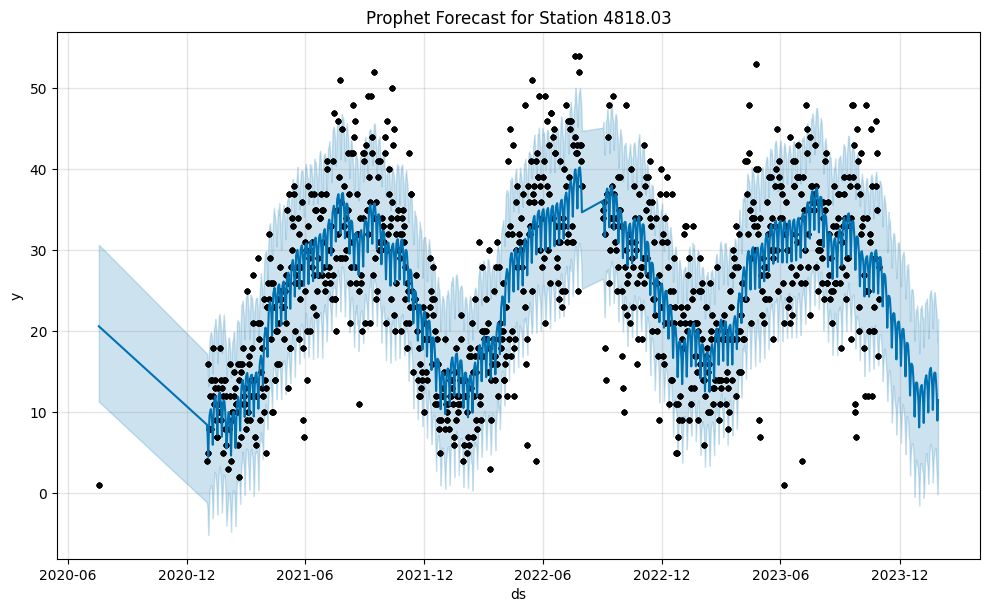

In [ ]:
# Plot the forecast
model.plot(forecast)
plt.title(f"Prophet Forecast for Station {station_id}")
plt.show()

In [ ]:
# Create future dataframe for forecasting for the length of the test data
# Instead of adding periods to the end of training data,
# we want to generate predictions for the specific dates in test_data
future = pd.DataFrame({'ds': test_data['ds']})

# Forecast
forecast = model.predict(future)

# Evaluation Metrics
# Filter forecast_values to include only dates in test_data
# (This line is no longer necessary as future is aligned with test_data)
forecast_values = forecast['yhat'].values
mae = mean_absolute_error(test_data['y'], forecast_values)
mse = mean_squared_error(test_data['y'], forecast_values)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_data['y'], forecast_values)

print(f"Evaluation Metrics for Prophet Model for Station {station_id}:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

Evaluation Metrics for Prophet Model for Station 4818.03:
MAE: 6.365714141571929
MSE: 62.02718060889982
RMSE: 7.875733655279349
MAPE: 0.2579065437840979


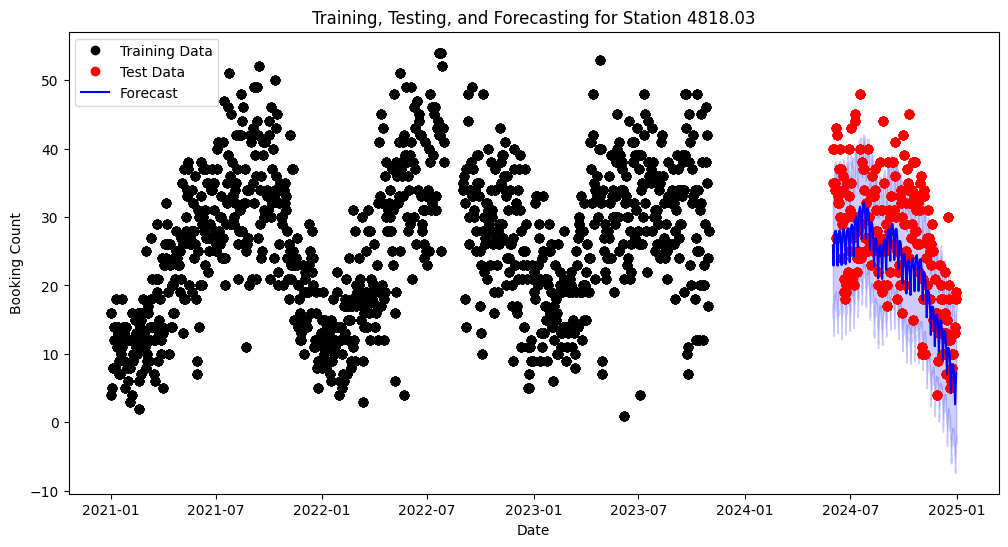

In [ ]:
# Remove the first data point from the training data for better visualization
train_data_cleaned = train_data.iloc[10:]

# Plotting training data, test data, and forecast
plt.figure(figsize=(12,6))

# Plot training data (black dots) after removing the first data point
plt.plot(train_data_cleaned['ds'], train_data_cleaned['y'], label='Training Data', color='black', marker='o', linestyle='None')

# Plot test data (red dots)
plt.plot(test_data['ds'], test_data['y'], label='Test Data', color='red', marker='o', linestyle='None')

# Plot forecast data (blue line with uncertainty bounds)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2)

# Labels and title
plt.title(f"Training, Testing, and Forecasting for Station {station_id}")
plt.xlabel('Date')
plt.ylabel('Booking Count')
plt.legend()

# Show the plot
plt.show()


In [ ]:
# prompt: print the head and tail of the datasets ive uploaded in content section

# Print the head of the datasets
print("Head of rides_2021:")
print(rides_2021.head())

print("\nHead of rides_2022:")
print(rides_2022.head())

print("\nHead of rides_2023:")
print(rides_2023.head())

print("\nHead of rides_2024:")
print(rides_2024.head())

print("\nHead of urban_features:")
print(urban_features.head())

print("\nHead of stations_coordinates:")
print(stations_coordinates.head())

print("\nHead of public_retail:")
print(public_retail.head())

# Print the tail of the datasets
print("\nTail of rides_2021:")
print(rides_2021.tail())

print("\nTail of rides_2022:")
print(rides_2022.tail())

print("\nTail of rides_2023:")
print(rides_2023.tail())

print("\nTail of rides_2024:")
print(rides_2024.tail())

print("\nTail of urban_features:")
print(urban_features.tail())

print("\nTail of stations_coordinates:")
print(stations_coordinates.tail())

print("\nTail of public_retail:")
print(public_retail.tail())
